In [1]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

In [4]:
# Define augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = FashionDataset(img_paths, labels, transform=transform)
batch_size = 5
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:
# Custom dataset class
class FashionDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None  # Skip if there's an error

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]  # Load actual label
        return image, label

# Dataset paths and transformations
dataset_folder = "test/image"
img_paths = [os.path.join(dataset_folder, img) for img in os.listdir(dataset_folder) if img.endswith(".jpg")]
img_paths = img_paths[:10000]  # Sample size limit

# Example labels (should load actual labels)
# Replace this with actual label loading from a file or other sources
labels = [torch.randint(0, 10, (1,)).item() for _ in range(len(img_paths))]  # Random labels for demo

# Create dataset and dataloader
dataset = FashionDataset(img_paths, labels, transform=transform)  # Fix here


In [5]:
import pandas as pd
# Create a DataLoader for your dataset (useful for batching)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Take a small sample of images and labels to display in a table (for example, 10 samples)
sample_imgs, sample_labels = next(iter(dataloader))

# Create a table for these images and labels
data = {
    "Image Path": img_paths[:10],  # Display only the first 10 for simplicity
    "Label": sample_labels.tolist()
}

df = pd.DataFrame(data)
print(df)  # Prints the table with image paths and labels

              Image Path  Label
0  test/image\000001.jpg      6
1  test/image\000002.jpg      3
2  test/image\000003.jpg      9
3  test/image\000004.jpg      5
4  test/image\000005.jpg      2
5  test/image\000006.jpg      7
6  test/image\000007.jpg      4
7  test/image\000008.jpg      4
8  test/image\000009.jpg      0
9  test/image\000010.jpg      8


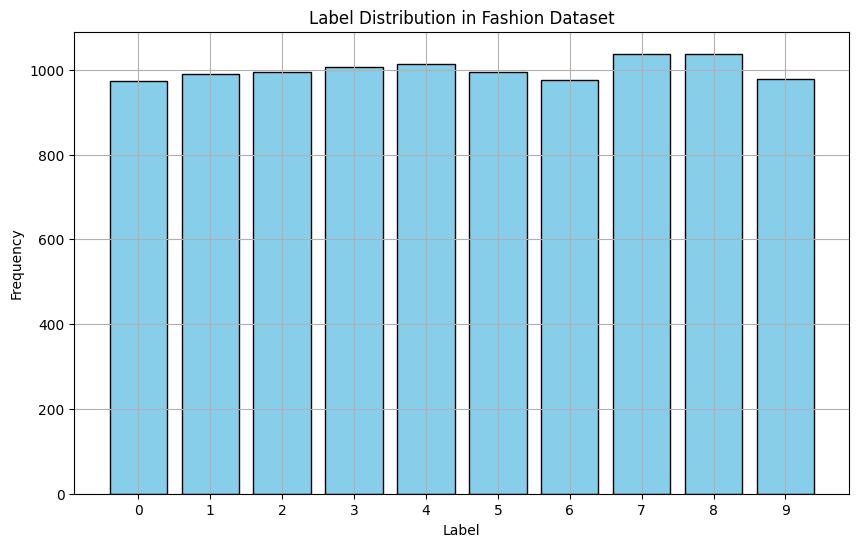

In [12]:
import torch
import matplotlib.pyplot as plt
import os

# Avoid OpenMP conflicts if using libraries with OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Ensure the dataset is available on the GPU
all_labels = torch.tensor([dataset[i][1] for i in range(len(dataset))], device="cuda")

# Transfer to CPU for plotting (matplotlib doesn't utilize GPU)
all_labels_cpu = all_labels.cpu().numpy()

# Generate the label distribution plot
plt.figure(figsize=(10, 6))
plt.hist(all_labels_cpu, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(range(10))  # Adjust to the number of classes
plt.title("Label Distribution in Fashion Dataset")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [10]:
# Attention module definition
class AttentionModule(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(AttentionModule, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W)
        key = self.key(x).view(batch_size, -1, H * W)
        value = self.value(x).view(batch_size, -1, H * W)

        attention = torch.bmm(query.permute(0, 2, 1), key)
        attention = self.softmax(attention)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        return out.view(batch_size, C, H, W)


In [8]:
# Model definition
class VirtualTryOnModel(nn.Module):
    def __init__(self):
        super(VirtualTryOnModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.attention = AttentionModule(128, reduction=8)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)

        # Calculate output size after convolutions
        sample_input = torch.zeros(1, 3, 128, 128)
        self.flattened_size = self._get_flattened_size(sample_input)
        self.fc = nn.Linear(self.flattened_size, 10)

    def _get_flattened_size(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.attention(x)
        x = torch.relu(self.conv3(x))
        return x.numel()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.attention(x)
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [11]:
# Xavier initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model = VirtualTryOnModel()
model.apply(initialize_weights)

# Device and criterion setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

class_counts = [100, 200, 150, 120, 130, 110, 140, 160, 180, 150]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

scaler = GradScaler()

cuda


C:\Users\Reach\AppData\Local\Temp\ipykernel_12232\16146158.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [13]:
# Training loop
num_epochs = 100
accumulation_steps = 4
losses = []
accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    optimizer.zero_grad()

    for i, (images, labels) in enumerate(dataloader):
        if images is None or labels is None:
            continue  # Skip any entries with loading errors

        images = images.to(device)
        labels = labels.to(device)  # Ensure labels are on the same device

        # Use 'cuda' in autocast as per the new API
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

    scheduler.step()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_samples * 100
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

print("Training Finished")

C:\Users\Reach\AppData\Local\Temp\ipykernel_14048\914682377.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100] Loss: 2.6593, Accuracy: 9.00%
Epoch [2/100] Loss: 2.3066, Accuracy: 10.60%
Epoch [3/100] Loss: 2.2952, Accuracy: 10.00%
Epoch [4/100] Loss: 2.2870, Accuracy: 9.60%
Epoch [5/100] Loss: 2.2925, Accuracy: 10.80%
Epoch [6/100] Loss: 2.2826, Accuracy: 8.80%
Epoch [7/100] Loss: 2.2777, Accuracy: 10.80%
Epoch [8/100] Loss: 2.2772, Accuracy: 10.60%
Epoch [9/100] Loss: 2.2719, Accuracy: 10.60%
Epoch [10/100] Loss: 2.2721, Accuracy: 11.00%
Epoch [11/100] Loss: 2.2639, Accuracy: 11.60%
Epoch [12/100] Loss: 2.2579, Accuracy: 11.80%
Epoch [13/100] Loss: 2.2525, Accuracy: 12.40%
Epoch [14/100] Loss: 2.2530, Accuracy: 12.60%
Epoch [15/100] Loss: 2.2558, Accuracy: 10.60%
Epoch [16/100] Loss: 2.2480, Accuracy: 12.80%
Epoch [17/100] Loss: 2.2457, Accuracy: 11.40%
Epoch [18/100] Loss: 2.2403, Accuracy: 11.80%
Epoch [19/100] Loss: 2.2345, Accuracy: 12.20%
Epoch [20/100] Loss: 2.2407, Accuracy: 11.80%
Epoch [21/100] Loss: 2.2412, Accuracy: 11.80%
Epoch [22/100] Loss: 2.2371, Accuracy: 11.80%


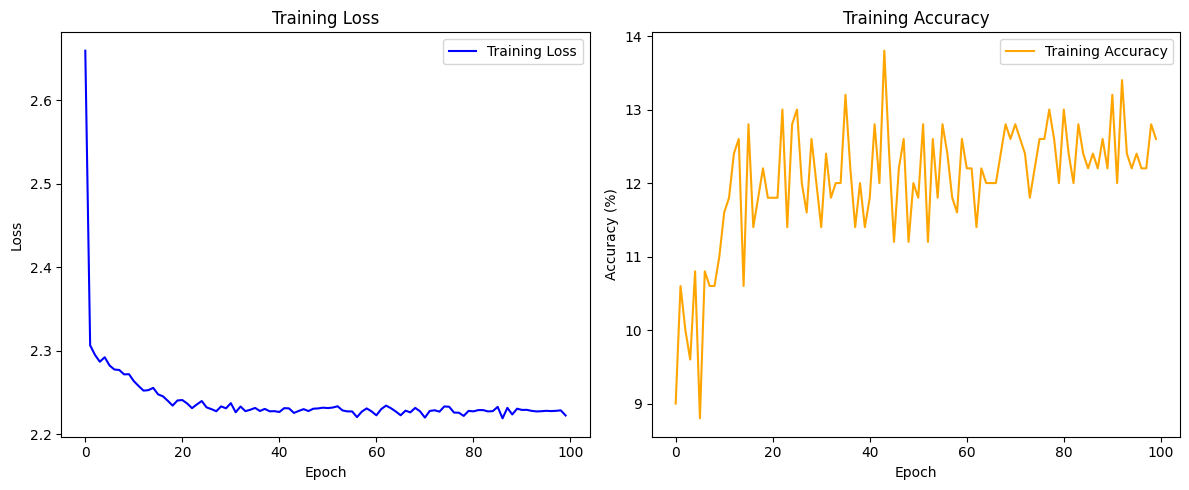

In [14]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()